In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt

1 Read the dataset 
========

In [2]:
data= pd.read_csv('../../Dataset/sep19SexAndAgeAddedFINAL DATASET_ver2.txt',sep=',')

data['FIELD_6_7']=np.min(data[['FIELD_6','FIELD_7']],axis=1) #combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)

(535169, 404)


In [3]:
# add Class to the dataset 
conditions = [
    (data.L100800 < 100)  ,
    (data.L100800 >= 100) & (data.L100800 < 126),
    (data.L100800 >= 126)]
choices = [0,1,2]
data['CLASS'] = np.select(conditions, choices, default=0) 

In [4]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia
print(data.shape)

(466680, 405)


In [5]:
# rename columns
data.rename(columns={'L104600': 'HBA1C', 
                     'L103000': 'Triglycerides',
                     'L100800':'fasting glucose', 
                     'S000300':'BMI', 
                     'S000501':'SBP', 
                     'S000502':'DBP', 
                     'L101700':'r-GTP gamma', 
                     'L103300':'Cardiac risk factor', 
                     'L190400':'Hemoglobin', 
                     'L190500':'HCT', 
                     'L100700':'Uric Acid', 
                     'L101300':'SGPT', 
                     'L190300':'RBC', 
                     'L102900':'total cholesterol', 
                     'L103100':'HDL-Cholesterol'
                    }, inplace=True)

In [6]:
# rename common field names
mydata=data.rename(columns={
                     'FIELD_33': 'Smoking', 
                     'FIELD_38': 'Drinking', 
                     'FIELD_40': 'physical_activity', 
                     'FIELD_31': 'Family_history', 
                     'FIELD_41': '_6_2_of_physical_activity_moderate', 
                     'FIELD_27': '_2_family_history_stroke', 
                     'FIELD_21': '_1_medication_heart_disease', 
                     'FIELD_14': 'Whether_one_diagnosis_disease', 
                     'FIELD_32': '_3B_hepatitis', 
                     'FIELD_42': '_6_3_of_physical_activity_walking', 
                     'FIELD_4' : 'blood_type', 
                     'FIELD_29': '_2_family_history_hypertension', 
                     'FIELD_3' : 'Blood_factor_RH_factor', 
                     'FIELD_19': '_1_drug_therapy_stroke'
                    }, inplace=True)




3.4 Final Selected Features
======

In [7]:
# based on the out put of section of 3.2 and 3.3 the following features are selected

finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid', 
               'Smoking', 'Drinking', 'physical_activity', 'Family_history','CLASS']

Classifier Model Test Based on the features 
========

In [8]:
randomseed=7
mydata=data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(142724, 12)


,HBA1C,Triglycerides,BMI,r-GTP gamma,SEX,AGE,Uric Acid,Smoking,Drinking,physical_activity,Family_history,CLASS
4,5.18,92.0,23.7,24.0,0.0,50.0,2.8,2.0,3.0,2.0,0.0,1
7,5.30,92.0,25.1,40.0,0.0,46.0,7.9,2.0,6.0,0.0,0.0,0
9,5.40,60.0,18.0,24.0,0.0,46.0,5.6,1.0,1.0,1.0,0.0,0
10,5.50,90.0,18.5,29.0,0.0,47.0,5.6,1.0,1.0,1.0,0.0,0
11,5.53,58.0,19.2,37.0,0.0,48.0,5.6,1.0,1.0,1.0,0.0,0


In [9]:
diabetic = mydata[mydata.CLASS==2]
prediabetic = mydata[mydata.CLASS==1]
normal = mydata[mydata.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

2451 36237 104036


In [10]:
diabetic_test = diabetic.sample(500,random_state=randomseed)
prediabetic_test = prediabetic.sample(500,random_state=randomseed)
normal_test = normal.sample(500,random_state=randomseed)

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(diabetic_train.shape[0],random_state=randomseed)

test=pd.concat([diabetic_test,prediabetic_test,normal_test])
train=pd.concat([diabetic_train,prediabetic_train,normal_train])

In [11]:
# generate synthetic dataset to overcome class imbalance
from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
print("Resampled dataset samples per class {}".format(Counter(y_res)))

train=pd.DataFrame(X_res,columns=list(train.columns[:-1]))
train['CLASS']=y_res

Resampled dataset samples per class Counter({2: 1951, 1: 1951, 0: 1951})


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=100,max_depth=10 )
rf.fit(train.iloc[:,:-1],train.iloc[:,-1])

RandomForestClassifier(max_depth=10, random_state=7)

0.7233333333333334


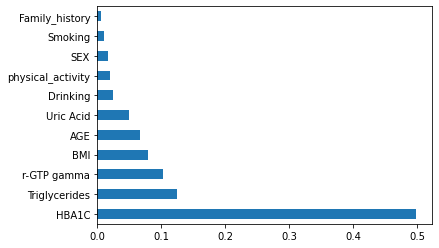

Index(['HBA1C', 'Triglycerides', 'r-GTP gamma', 'BMI', 'AGE', 'Uric Acid',
       'Drinking', 'physical_activity', 'SEX', 'Smoking', 'Family_history'],
      dtype='object')
HBA1C                0.497914
Triglycerides        0.124099
r-GTP gamma          0.103324
BMI                  0.079428
AGE                  0.066070
Uric Acid            0.049341
Drinking             0.024628
physical_activity    0.019864
SEX                  0.017419
Smoking              0.011316
Family_history       0.006597
dtype: float64


In [13]:
ypred= rf.predict(test.iloc[:,:-1])

score=rf.score(test.iloc[:,:-1],test.iloc[:,-1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,:-1].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)
print(feat_importances.nlargest(16))

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test.iloc[:,-1],ypred)

array([[352, 138,  10],
       [128, 318,  54],
       [  6,  79, 415]], dtype=int64)

In [15]:
print("Accuracy on training set: {:.3f}".format(rf.score(train.iloc[:,:-1],train.iloc[:,-1])))
print("Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:,:-1],test.iloc[:,-1] ))) 
ypred=rf.predict(test.iloc[:,:-1])

confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],ypred))
confmatrx.head()


Accuracy on training set: 0.857
Accuracy on test set: 0.723


,0,1,2
0,352,138,10
1,128,318,54
2,6,79,415


In [16]:

from sklearn.metrics import classification_report 
print(classification_report(test.iloc[:,-1], ypred))


              precision    recall  f1-score   support

           0       0.72      0.70      0.71       500
           1       0.59      0.64      0.61       500
           2       0.87      0.83      0.85       500

    accuracy                           0.72      1500
   macro avg       0.73      0.72      0.73      1500
weighted avg       0.73      0.72      0.73      1500



In [17]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed,num_class = 3)

xgb_model.fit(train.iloc[:,:-1],train.iloc[:,-1])

y_pred = xgb_model.predict((test.iloc[:,:-1]))

print('accuracy \t',m.accuracy_score(test.iloc[:,-1],y_pred))
confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],y_pred))
confmatrx.head()

accuracy 	 0.6973333333333334


,0,1,2
0,338,153,9
1,139,298,63
2,10,80,410


In [18]:
print(classification_report(test.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       500
           1       0.56      0.60      0.58       500
           2       0.85      0.82      0.84       500

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



===============================
==========

In [19]:
import pickle

with open('DiabeticClassifierModel', 'wb') as f:
    pickle.dump(xgb_model, f)




In [20]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed,num_class = 3)
xgb_model.fit(train.iloc[:,:-1],train.iloc[:,-1])
y_pred = xgb_model.predict((test.iloc[:,:-1]))
print('accuracy \t',m.accuracy_score(test.iloc[:,-1],y_pred))

accuracy 	 0.6973333333333334
